# install fiftyone

[FiftyOne](https://voxel51.com/docs/fiftyone/index.html) is open-source tool for building high-quality datasets and computer vision models.


In [ ]:
!pip install fiftyone


In [127]:
import fiftyone as fo
import fiftyone.zoo as foz
from fiftyone.core import dataset as D
from fiftyone import ViewField as F
import tensorflow as tf

import os


# Functions to build customized dataset


In [128]:
classes = ["apple", "orange", "banana", "book"]
oi_classes = [c[0].upper() + c[1:] for c in classes]

In [129]:
def build_dataset(
    classes,
    source_dataset='open-images-v6',
    split="validation",
    label_types=['detections'],
    max_samples_per_class=10,
    delete_exist_dataset=False
    ):

    all_calss_dataset_name = f'{source_dataset}-{split}-{max_samples_per_class}'
    dataset = None
    if D.dataset_exists(all_calss_dataset_name):
        if delete_exist_dataset:
            print(f'Delete existing dataset {all_calss_dataset_name}')
            D.delete_dataset(all_calss_dataset_name)
        else:
            print(f'Load existing dataset {all_calss_dataset_name}')
            dataset = D.load_dataset(all_calss_dataset_name)
    if dataset:
        return dataset

    single_class_datasets = []
    for c in classes:
        dataset_name = f'{source_dataset}-{split}-{c}-{max_samples_per_class}'
        single_class_dataset = None
        if D.dataset_exists(dataset_name):
            if delete_exist_dataset:
                print(f'Delete existing dataset {dataset_name}')
                D.delete_dataset(dataset_name)
            else:
                print(f'Load existing dataset {dataset_name}')
                single_class_dataset = D.load_dataset(dataset_name)

        if not single_class_dataset:
            single_class_dataset = foz.load_zoo_dataset(
                source_dataset,
                split=split,
                label_types=label_types,
                classes=[c], 
                max_samples=max_samples_per_class,
                dataset_name=dataset_name
            )
        single_class_datasets.append(single_class_dataset)

    dataset = single_class_datasets[0].clone(all_calss_dataset_name)
    for d in single_class_datasets[1:]:
        dataset.merge_samples(d)
    return dataset


In [130]:
# Bboxes are in [top-left-x, top-left-y, width, height] format
bbox_area = F("bounding_box")[2] * F("bounding_box")[3]


def build_dateset_view(dataset,
                       dataset_type='open_image',
                       IsOccluded=None,
                       IsTruncated=None,
                       IsGroupOf=None,
                       IsDepiction=None,
                       IsInside=None,
                       iscrowd=None,
                       valid_labels=oi_classes,
                       bbox_area_lower_bound=None):
    if dataset_type =='open_image':
        gt_field = 'detections'
    else:
        gt_field = 'ground_truth'
    view = dataset
    if valid_labels:
        view = view.filter_labels(gt_field,
                                  F("label").is_in(valid_labels),
                                  only_matches=False)
    if IsOccluded is not None:
        view = view.filter_labels(gt_field,
                                  F("IsOccluded") == IsOccluded,
                                  only_matches=True)
    if IsTruncated is not None:
        view = view.filter_labels(gt_field,
                                  F("IsTruncated") == IsTruncated,
                                  only_matches=True)
    if IsGroupOf is not None:
        view = view.filter_labels(gt_field,
                                  F("IsGroupOf") == IsGroupOf,
                                  only_matches=True)
    if IsDepiction is not None:
        view = view.filter_labels(gt_field,
                                  F("IsDepiction") == IsDepiction,
                                  only_matches=True)
    if IsInside is not None:
        view = view.filter_labels(gt_field,
                                  F("IsInside") == IsInside,
                                  only_matches=True)
    if iscrowd is not None:
        view = view.filter_labels(gt_field,
                                  F("iscrowd") == iscrowd,
                                  only_matches=True)
    if bbox_area_lower_bound:
        view = view.filter_labels(
            gt_field,
            bbox_area > bbox_area_lower_bound,
        )
    return view


In [131]:
def export_dataset_or_view(
    dataset_or_view,
    export_dir,
    label_field,
    dataset_type=fo.types.COCODetectionDataset,
    overwrite=False,
    tf_file_name=None,
):
    dataset_or_view.export(
        export_dir=export_dir,
        dataset_type=dataset_type,
        label_field=label_field,
        overwrite=overwrite
    )

    if dataset_type == fo.types.TFObjectDetectionDataset and tf_file_name:
        if not tf_file_name.endswith('.records'):
            tf_file_name += '.records'
        source = os.path.join(export_dir, 'tf.records')
        target = os.path.join(export_dir, tf_file_name)
        if os.path.exists(target) and overwrite:
            os.remove(target)
        os.rename(source, target)

In [132]:
def check_tf_record(filepath, take_num=1):
    raw_dataset = tf.data.TFRecordDataset(filepath)
    for raw_record in raw_dataset.take(take_num):
        example = tf.train.Example()
        example.ParseFromString(raw_record.numpy())
        print(example)
        # print('-' * 32)
        # n = len(example.features)
        # for i in range(n):
        #     feature = example.features[i]
        #     if feature.key != 'image/encoded':
        #         print(feature)


# Open Image Dataset

[fiftyone_open_images.ipynb - Colaboratory](https://colab.research.google.com/github/voxel51/fiftyone/blob/v0.13.3/docs/source/tutorials/open_images.ipynb#scrollTo=4TvnIN7xRtuh)


In [133]:
ds = build_dataset(oi_classes, delete_exist_dataset=False)

Load existing dataset open-images-v6-validation-10


In [ ]:
session = fo.launch_app(ds)

In [ ]:
view  = build_dateset_view(ds, IsGroupOf=False, bbox_area_lower_bound=0.1)
session = fo.launch_app(view=view)

In [81]:
counts = view.count_values("detections.detections.label")
counts

{'Banana': 1, 'Orange': 9, 'Apple': 7, 'Book': 1}

Load existing dataset open-images-v6-train-1000
{'Orange': 450, 'Banana': 493, 'Book': 648, 'Apple': 539}



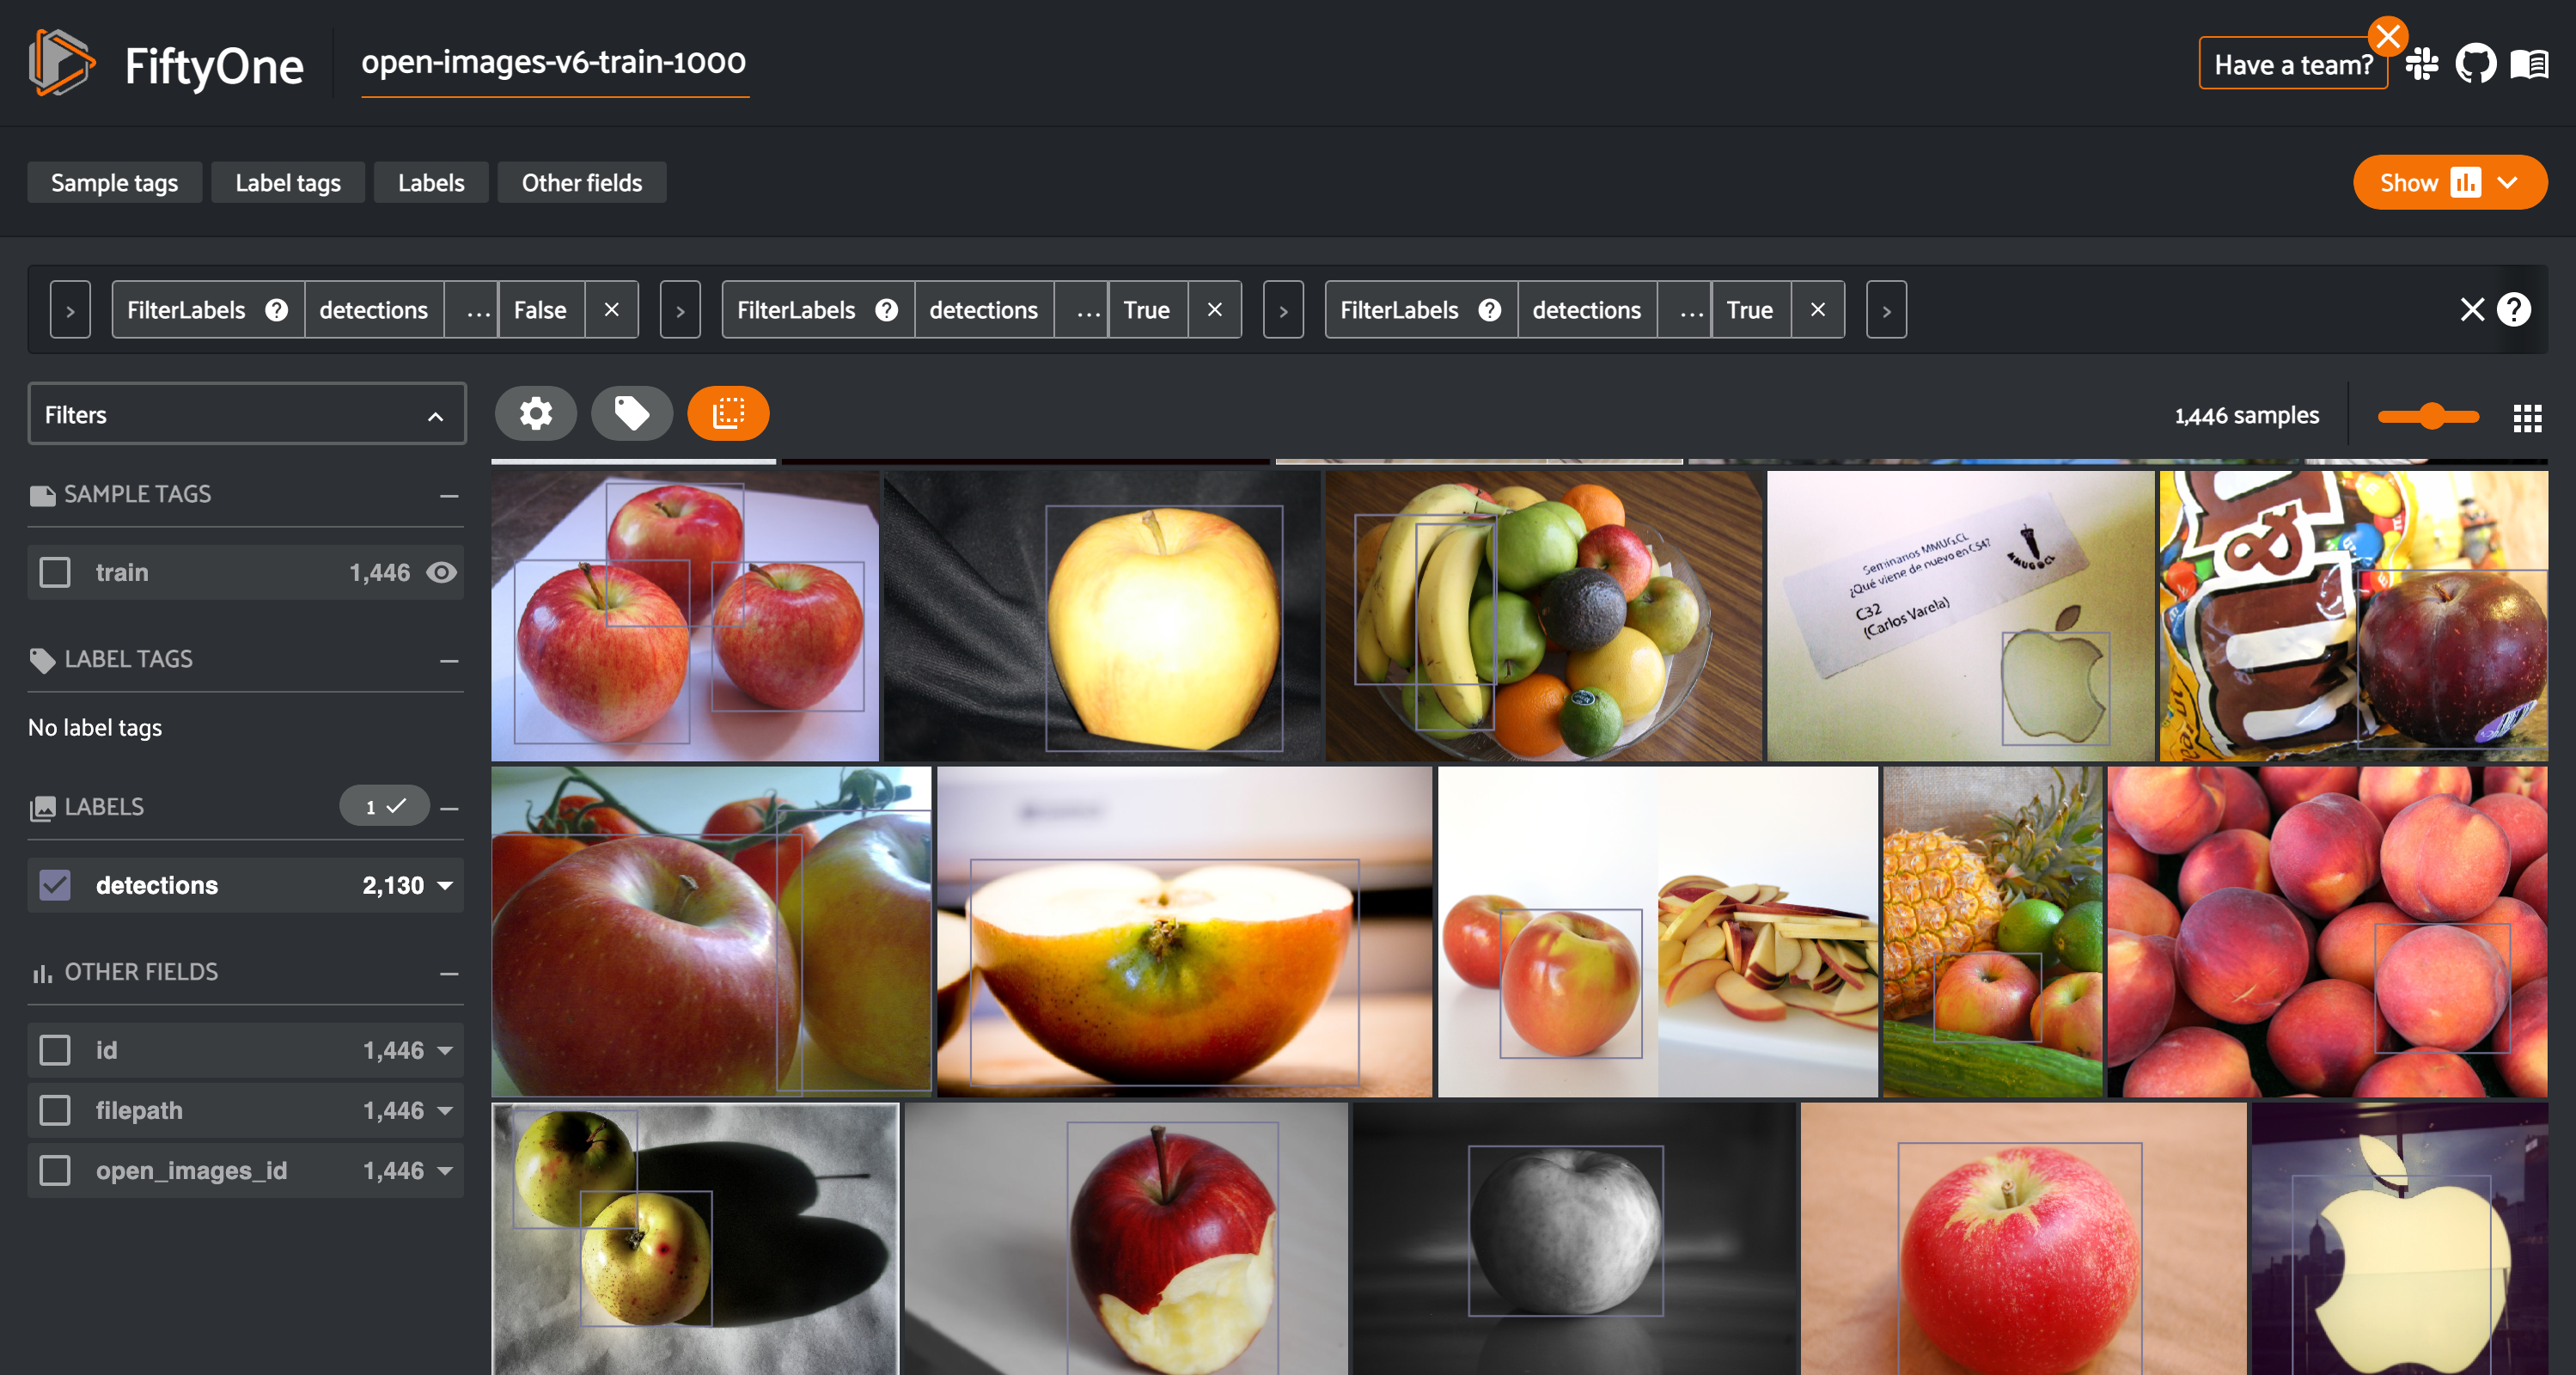

In [134]:
train_ds = build_dataset(oi_classes, split='train', max_samples_per_class=1000, delete_exist_dataset=False)
train_filterd_view  = build_dateset_view(train_ds, IsGroupOf=False, bbox_area_lower_bound=0.1)
counts = train_filterd_view.count_values("detections.detections.label")
print(counts)
session = fo.launch_app(view=train_filterd_view)

In [109]:
export_dataset_or_view(train_filterd_view,
                       '../workspace/data/open_image_train_filtered_as_coco',
                       label_field='detections')


 100% |███████████████| 1446/1446 [27.5s elapsed, 0s remaining, 45.1 samples/s]      


In [111]:
export_dataset_or_view(train_filterd_view,
                       '../workspace/data',
                       label_field='detections',
                       tf_file_name='train',
                       dataset_type=fo.types.TFObjectDetectionDataset)


   0% |/--------------|    6/1446 [118.3ms elapsed, 28.4s remaining, 50.7 samples/s] 

2021-10-10 16:05:34.230313: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 100% |███████████████| 1446/1446 [18.9s elapsed, 0s remaining, 81.3 samples/s]      


In [ ]:
open_image_test_ds = build_dataset(oi_classes,
                                   split='test',
                                   max_samples_per_class=1000,
                                   delete_exist_dataset=False)
open_image_test_filterd_view = build_dateset_view(open_image_test_ds,
                                                  IsGroupOf=False,
                                                  bbox_area_lower_bound=0.1)
counts = open_image_test_filterd_view.count_values(
    "detections.detections.label")
print(counts)
# session = fo.launch_app(view=open_image_test_filterd_view)
export_dataset_or_view(
    open_image_test_filterd_view,
    '../workspace/data/test',
    label_field='detections',
    dataset_type=fo.types.TFObjectDetectionDataset)


In [116]:
open_image_validation_ds = build_dataset(oi_classes,
                                   split='validation',
                                   max_samples_per_class=1000,
                                   delete_exist_dataset=False)
open_image_validation_filterd_view = build_dateset_view(open_image_validation_ds,
                                                  IsGroupOf=False,
                                                  bbox_area_lower_bound=0.1)
counts = open_image_validation_filterd_view.count_values(
    "detections.detections.label")
print(counts)
# session = fo.launch_app(view=open_image_validation_filterd_view)
export_dataset_or_view(
    open_image_validation_filterd_view,
    '../workspace/data',
    tf_file_name='validation',
    label_field='detections',
    dataset_type=fo.types.TFObjectDetectionDataset)


Load existing dataset open-images-v6-validation-1000
{'Banana': 6, 'Book': 32, 'Apple': 34, 'Orange': 47}
Directory '../workspace/data' already exists; export will be merged with existing files
 100% |███████████████████| 77/77 [1.0s elapsed, 0s remaining, 76.5 samples/s]         


In [126]:
check_tf_record('../workspace/data/validation.records')

features {
  feature {
    key: "image/encoded"
    value {
      bytes_list {
        value: "\377\330\377\340\000\020JFIF\000\001\001\001\000H\000H\000\000\377\333\000C\000\001\001\001\001\001\001\001\001\001\001\001\001\001\001\001\002\001\001\001\001\001\002\001\001\001\002\002\002\002\002\002\002\002\002\003\003\004\003\003\003\003\003\002\002\003\004\003\003\004\004\004\004\004\002\003\005\005\004\004\005\004\004\004\004\377\333\000C\001\001\001\001\001\001\001\002\001\001\002\004\003\002\003\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\004\377\300\000\021\010\002\253\004\000\003\001!\000\002\021\001\003\021\001\377\304\000\037\000\000\002\002\003\001\001\001\001\001\000\000\000\000\000\000\000\005\006\004\007\003\010\t\002\001\n\000\013\377\304\000I\020\000\001\003\002\005\001\005\006\004\004\006\002\001\003\000\013\001\002\003\00

In [23]:
sample = dataset.first()
print(sample)

<Sample: {
    'id': '61615cbff970cbb8cdf17a7e',
    'media_type': 'image',
    'filepath': '/Users/sg99018ml/fiftyone/open-images-v6/validation/data/04311ae05c027377.jpg',
    'tags': BaseList(['validation']),
    'metadata': None,
    'segmentations': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61615cbff970cbb8cdf17a78',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'Book',
                'bounding_box': BaseList([0.521875, 0.027083, 0.301563, 0.308334]),
                'mask': array([[False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       ...,
                       [False, False, False, ..., False, False, False],
                       [False, False, False, ..., False, False, False],
                       [Fal

In [24]:
sample['segmentations']['detections'][0]

<Detection: {
    'id': '61615cbff970cbb8cdf17a78',
    'attributes': BaseDict({}),
    'tags': BaseList([]),
    'label': 'Book',
    'bounding_box': BaseList([0.521875, 0.027083, 0.301563, 0.308334]),
    'mask': array([[False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           ...,
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False],
           [False, False, False, ..., False, False, False]]),
    'confidence': None,
    'index': None,
}>

In [ ]:
from fiftyone import ViewField as F
# TODO get samples with desired classes and not crowed
# Sort samples with the less objects first
obj_count_view = dataset.sort_by(F("ground_truth.detections").length(),
                                 reverse=False)
obj_count_view = dataset.sort_by(F("detections.detections").length(), reverse=False)

session.view = obj_count_view

# Check with coco2017 dataset

[What Object Categories / Labels Are In COCO Dataset? | Amikelive | Technology Blog](https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/)


In [106]:
coco_train_ds = build_dataset(classes,
                              source_dataset='coco-2017',
                              split='train',
                              max_samples_per_class=1000)
coco_train_filterd_view = build_dateset_view(coco_train_ds,
                                             dataset_type='coco',
                                             valid_labels=classes,
                                             iscrowd=0,
                                             bbox_area_lower_bound=0.1)
counts = coco_train_filterd_view.count_values("ground_truth.detections.label")
print(counts)
session = fo.launch_app(view=coco_train_filterd_view)

Load existing dataset coco-2017-train-1000
{'orange': 497, 'apple': 546, 'banana': 843, 'book': 148}


In [88]:
coco_train_ds

Name:        coco-2017-train-1000
Media type:  image
Num samples: 3066
Persistent:  False
Tags:        ['train']
Sample fields:
    id:           fiftyone.core.fields.ObjectIdField
    filepath:     fiftyone.core.fields.StringField
    tags:         fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:     fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    ground_truth: fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.labels.Detections)

In [90]:
sample = coco_train_ds.first()
print(sample)

<Sample: {
    'id': '61629648f970cbb8cdf26fbe',
    'media_type': 'image',
    'filepath': '/Users/sg99018ml/fiftyone/coco-2017/train/data/000000000670.jpg',
    'tags': BaseList(['train']),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 640,
        'height': 427,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '61629648f970cbb8cdf26fa8',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'apple',
                'bounding_box': BaseList([
                    0.292578125,
                    0.565175644028103,
                    0.092078125,
                    0.16028103044496486,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'food',
                'iscrowd': 0,

In [ ]:
sample

<Sample: {
    'id': '615cf39ae068c36fa3ca3cb4',
    'media_type': 'image',
    'filepath': '/root/fiftyone/coco-2017/validation/data/000000000139.jpg',
    'tags': BaseList(['validation']),
    'metadata': <ImageMetadata: {
        'size_bytes': None,
        'mime_type': None,
        'width': 640,
        'height': 426,
        'num_channels': None,
    }>,
    'ground_truth': <Detections: {
        'detections': BaseList([
            <Detection: {
                'id': '615cf39ae068c36fa3ca3ca0',
                'attributes': BaseDict({}),
                'tags': BaseList([]),
                'label': 'potted plant',
                'bounding_box': BaseList([
                    0.37028125,
                    0.3345305164319249,
                    0.038593749999999996,
                    0.16314553990610328,
                ]),
                'mask': None,
                'confidence': None,
                'index': None,
                'supercategory': 'furniture',
         

In [ ]:
counts = dataset.count_values("ground_truth.detections.label")
counts

{'apple': 9,
 'backpack': 1,
 'banana': 23,
 'bed': 2,
 'book': 77,
 'bottle': 8,
 'bowl': 3,
 'cell phone': 1,
 'chair': 35,
 'clock': 1,
 'couch': 5,
 'cup': 7,
 'dining table': 11,
 'dog': 1,
 'donut': 1,
 'fork': 2,
 'keyboard': 2,
 'knife': 1,
 'laptop': 4,
 'microwave': 2,
 'mouse': 2,
 'orange': 4,
 'oven': 1,
 'person': 11,
 'pizza': 2,
 'potted plant': 10,
 'refrigerator': 3,
 'sink': 1,
 'spoon': 1,
 'tie': 1,
 'tv': 5,
 'vase': 9}

In [ ]:
from fiftyone import ViewField as F
# TODO get samples with desired classes and not crowed
# Sort samples with the less objects first
obj_count_view = dataset.sort_by(F("ground_truth.detections").length(), reverse=False)

session.view = obj_count_view